<a href="https://colab.research.google.com/github/Nighty13/SuperResolutionCNN/blob/master/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Super Resolution Convolutional Neural Network for Image Restoration***
used paper link : https://arxiv.org/abs/1501.00092.

In [0]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage
print('Python:{}'.format(sys.version))
print('Keras:{}'.format(keras.__version__))
print('OpenCV:{}'.format(cv2.__version__))
print('NumPY:{}'.format(numpy.__version__))
print('Matplotlib:{}'.format(matplotlib.__version__))
print('Skimage:{}'.format(skimage.__version__))

In [0]:
#import necessary packages
from keras.models import Sequential
from keras.layers import Conv2D,Input
from keras.optimizers import SGD,Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math 
import os
%matplotlib inline

## **Recover Zip file from Google Drive & Unzip**

In [0]:
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

# New Section

# New Section

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

In [0]:
example_file_name = 'Source.zip'
example_file_id = get_file_id(example_file_name)

In [0]:
move_from_drive_to_disk([example_file_name], ['Source.zip'])

Downloaded 6305897/6305897 bytes


In [0]:
!unzip Source.zip

Archive:  Source.zip
   creating: Source/
  inflating: Source/baboon.bmp       
  inflating: Source/baby_GT.bmp      
  inflating: Source/barbara.bmp      
  inflating: Source/bird_GT.bmp      
  inflating: Source/butterfly_GT.bmp  
  inflating: Source/coastguard.bmp   
  inflating: Source/comic.bmp        
  inflating: Source/face.bmp         
  inflating: Source/flowers.bmp      
  inflating: Source/foreman.bmp      
  inflating: Source/head_GT.bmp      
  inflating: Source/lenna.bmp        
  inflating: Source/monarch.bmp      
  inflating: Source/pepper.bmp       
  inflating: Source/ppt3.bmp         
  inflating: Source/woman_GT.bmp     
  inflating: Source/zebra.bmp        


In [0]:
!ls Source

baboon.bmp   butterfly_GT.bmp  flowers.bmp  monarch.bmp   zebra.bmp
baby_GT.bmp  coastguard.bmp    foreman.bmp  pepper.bmp
barbara.bmp  comic.bmp	       head_GT.bmp  ppt3.bmp
bird_GT.bmp  face.bmp	       lenna.bmp    woman_GT.bmp


In [0]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [0]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = h / factor
        new_width = w / factor
        
        # resize the image - down
        img = cv2.resize(img, (int(new_width), int(new_height)), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [0]:
!mkdir images

In [0]:
prepare_images('Source',2)

Saving butterfly_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving head_GT.bmp
Saving flowers.bmp
Saving ppt3.bmp
Saving baboon.bmp
Saving baby_GT.bmp
Saving comic.bmp
Saving coastguard.bmp
Saving lenna.bmp
Saving zebra.bmp
Saving face.bmp
Saving foreman.bmp
Saving pepper.bmp
Saving woman_GT.bmp
Saving monarch.bmp


In [0]:
# test the generated images using the image quality metrics

for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('Source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.8791344763843051

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.2237755102041
SSIM: 0.8011121330733371

flowers.bmp
PSNR: 27.454504805386144
MSE: 350.55093922651935
SSIM: 0.8697286286974628

ppt3.bmp
PSNR: 24.84926168950471
MSE: 638.6684263912582
SSIM: 0.9284023942315316

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.629277587900277

baby_GT.bmp
PSNR: 34.371806409661986
MSE: 71.28874588012695
SSIM: 0.9356987872724932

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.8347335416398209

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

lenna.bmp
PSNR: 31.47349297867539
MSE: 138.94800567626953
SSIM: 0.8460989200521499

zebra.bmp
PSNR: 27.909840639329513
MSE: 315.65854595

# **Deploying the SRCNN**



*  Now that we have defined our model, we can use it for single-image super-resolution. However, before we do this, we will need to define a couple of image processing functions. Furthermore, it will be necessary to preprocess the images extensively before using them as inputs to the network. This processing will include cropping and color space conversions.
*  Additionally, to save us the time it takes to train a deep neural network, we will be loading pre-trained weights for the SRCNN. These weights can be found at the following GitHub page: https://github.com/MarkPrecursor/SRCNN-keras
* Once we have tested our network, we can perform single-image super-resolution on all of our input images. Furthermore, after processing, we can calculate the PSNR, MSE, and SSIM on the images that we produce. We can save these images directly or create subplots to conveniently display the original, low resolution, and high resolution images side by side. 






In [0]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [0]:
!git clone https://github.com/MarkPrecursor/SRCNN-keras

Cloning into 'SRCNN-keras'...
remote: Enumerating objects: 33, done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (33/33), done.


In [0]:
!ls SRCNN-keras # we only need 3051crop_weight_200.h5

3051crop_weight_200.h5	main.py		       prepare_data.py	 readme.md
butterfly_GT.bmp	m_model_adam_new30.h5  prepare_data.pyc  result.png
input.jpg		pre_adam30.jpg	       psnr.py		 SRCNN.png


In [0]:
#define necessary image processing functions

def modcrop(img,scale):
  
  tmpsz = img.shape
  sz = tmpsz[0:2]
  sz = sz - np.mod(sz,scale)
  img = img[0:sz[0],1:sz[1]]
  return img

def shave(image,border):
  img=image[border:-border,border:-border]
  return img

In [0]:
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('SRCNN-keras/3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('Source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

Degraded Image: 
PSNR: 27.248686459559124
MSE: 367.56400047398984
SSIM: 0.8690622024599293

Reconstructed Image: 
PSNR: 29.660220614739448
MSE: 210.95001184974524
SSIM: 0.8989099578687939



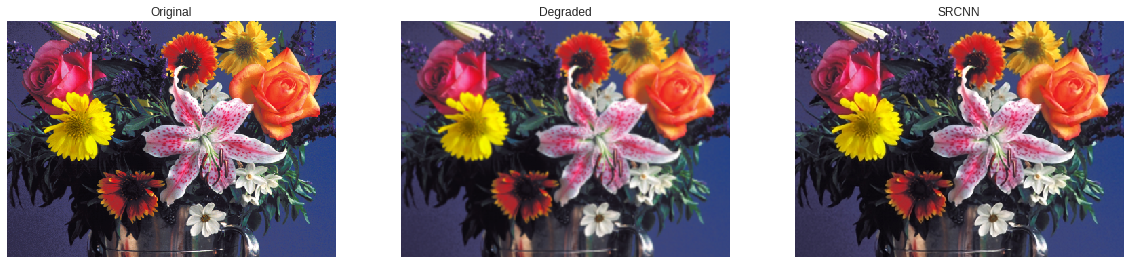

In [0]:
ref, degraded, output, scores = predict('images/flowers.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [22]:
!mkdir output
for file in os.listdir('images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

mkdir: cannot create directory ‘output’: File exists
Saving butterfly_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving head_GT.bmp
Saving flowers.bmp
Saving ppt3.bmp
Saving baboon.bmp
Saving baby_GT.bmp
Saving comic.bmp
Saving coastguard.bmp
Saving lenna.bmp
Saving zebra.bmp
Saving face.bmp
Saving foreman.bmp
Saving pepper.bmp
Saving woman_GT.bmp
Saving monarch.bmp


In [23]:
example_file_name = 'RealTest.zip'
example_file_id = get_file_id(example_file_name)

In [24]:
move_from_drive_to_disk([example_file_name], ['RealTest.zip'])

Downloaded 919645/919645 bytes


In [25]:
!unzip RealTest.zip

Archive:  RealTest.zip
   creating: testPersonnal/
  inflating: testPersonnal/test02.bmp  


In [0]:
# load the srcnn model with weights
srcnn = model()
srcnn.load_weights('SRCNN-keras/3051crop_weight_200.h5')
image_path='testPersonnal/test02.bmp'
# load the degraded and reference images
path, file = os.path.split(image_path)
degraded = cv2.imread(image_path)
# preprocess the image with modcrop
degraded = modcrop(degraded, 3)
# convert the image to YCrCb - (srcnn trained on Y channel)
temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
# create image slice and normalize  
Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
# perform super-resolution with srcnn
pre = srcnn.predict(Y, batch_size=1)    
#post-process output
pre *= 255
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)
    
 # copy Y channel back to image and convert to BGR
temp = shave(temp, 6)
temp[:, :, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
# remove border from reference and degraged image
#ref = shave(ref.astype(np.uint8), 6)
degraded = shave(degraded.astype(np.uint8), 6)
    
# image quality calculations
#scores = []
#scores.append(compare_images(degraded, ref))
#scores.append(compare_images(output, ref))
    
# return images and scores
#return ref, degraded, output, scores
# display images as subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[0].set_title('Degraded')
axs[1].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[1].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])